# <center>Machine Learning Lab: Exercise Sheet 10</center>
<center> <b>Submitted By: Mohit Bansal</b></center>
<center> <b>Student ID: 279314</b></center>

### Datasets:
+ **IRIS dataset D1:** https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/iris.scale
+ **rcv1v2 (topics; subsets D2:** https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multilabel.html#rcv1v2(topics;subsets)
+ **20Newsgroups dataset D3:** http://qwone.com/~jason/20Newsgroups/

# Exercise 1: Implement K Means clustering algorithm (10 Points)

+ Implement K-means algorithm
+ You should use D1 or D2 datasets
+ Your algorithm should be able to handle sparse data
+ Finally, you should also choose a criterion for selecting an optimal value of k (number of clusters)


## Solution

The implementation can be divided into the following:

+ **Find Initial Centroids**: Choose k centroids in random.
+ **Distance Calculation**: Finding the distance between each of the datapoints with each of the centroids. This distance metric is used to find the which cluster the points belong to.
+ **Re-calculating the centroids**: Find the new values for centroid.
+ **Stop the iteration**: Stop the algorithm when the difference between the old and the new centroids is negligible.


+ **Selecting Optimal K**: We will use the elbow-method to calculate optimal K

### Step 0: Loading Data

We will be using the IRIS dataset for this excercise. The data is in SVMlight format. We will load it into a sparse matrix

In [130]:
# Import Libraries
import os
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn.datasets import dump_svmlight_file, load_svmlight_file

# Read the training data
path = "/Users/mundanemohit/Google Drive/My Work/MSc. Data Analytics/WiSe 18/\
3113 Machine Learning Lab/Excercises/Ex10"
os.chdir(path)
irisDF = load_svmlight_file('iris.scale.txt')

# Check format of iris data
irisDF[0]

<150x4 sparse matrix of type '<class 'numpy.float64'>'
	with 587 stored elements in Compressed Sparse Row format>

### Step 1: Distance Calculation

Create a function for calculating distances between centroids and data points.

In [87]:
def dist(a, b, ax=1):
    return np.round(np.linalg.norm(a - b, axis=ax), 5)

## Step 2, 3, 4: Initializating & Optimizing Centroids 

+ We will implement a kmeans functions which takes in the data & number of clusters as the input
+ We will start with k random centroids
+ The function will converge when the centroid updates stop (i.e. $C_{old}$ - $C_{new}$ is 0)

In [126]:
def kmeans(X, k=3):
    # store dimensions of the datasets
    m, n = X.shape[0], X.shape[1]

    # Coordinates of random centroids
    C = np.zeros([n, k])

    # Initialize k centroids based on range of values
    for i in range(n):
        C[i] = np.random.uniform(np.min(X[:, i]), np.max(X[:,i]), (k, ))
    C = C.T

    # To store the value of centroids when it updates
    C_old = np.zeros(C.shape)

    # Cluster Lables for each point - Start with labelling them all as 0
    clusters = np.zeros(m)

    # Distance between new centroids and old centroids
    centroid_err = []
    centroid_err.append(dist(C, C_old, None))

    # Loop will run till the error becomes zero (no more updates)
    while(dist(C, C_old, None) != 0):
        # Assigning each value to its closest cluster
        for i in range(m):
            distances = dist(X[i].todense(), C)
            cluster = np.argmin(distances)
            clusters[i] = cluster

        # Storing the old centroid values
        C_old = deepcopy(C)

        # Finding the new centroids by taking the average value
        for i in range(k):
            points = [X[j].todense() for j in range(m) if clusters[j] == i]
            
            # If the centroid has no points, do not update it
            if np.isnan(points).all():
                C[i] = C_old[i]
            else:
                C[i] = np.mean(points, axis=0)

        # Appending error values
        centroid_err.append(dist(C, C_old, None))
    
    # print descent of error
    #print("# CLUSTERS: ", k)
    
    # Calculate final distance between centroids and points
    error = []
    for i in range(k):
        points = [X[j].todense() for j in range(m) if clusters[j] == i]
        
        if not(np.isnan(points).all()):
            D = dist(points, C[i], ax = 1)
            error.append(D.mean())
    return C, np.mean(error)    

### Let's see our code in action

In [132]:
X = irisDF[0]

C, error = kmeans(X, k=3)
print("Centroids \n ", C)
print("Mean Error: ", error)

Centroids 
  [[ 0.41452981 -0.09829064  0.59408938  0.64957267]
 [-0.60777778  0.18166667 -0.84271174 -0.88000014]
 [-0.11748638 -0.38524591  0.15143093  0.09836071]]
Mean Error:  0.16260368057306993


### Step 5: Calculating Optimal k-value

We will plot the average k-means error on test set for each k value and will take the elbow point as the optimal k

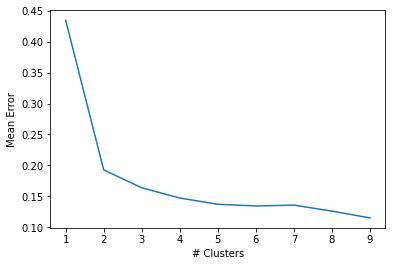

In [146]:
E = []
for i in range(1, 10):
    C, error = kmeans(X, k=i)
    E.append(error)

plt.plot(range(1,10), E)
plt.xlabel("# Clusters")
plt.ylabel("Mean Error")
plt.show()

So we can see that the elbow point occurs when k = 2. This means that according to our algorithm, the optimal number of clusters should be 2 in order to minimize error. This isn't really in line with the 3 clusters that were originally given to us in the iris dataset. However, the error value does keep decreasing for k = 3, 4. So, ideally we can try (2, 4) clusters and see which scenario works best for us.

# Exercise 2: Cluster news articles (10 Points)
D3 is 20Newsgroups dataset (download “20news-bydate.tar.gz”). Each news article is stored as a file in its group folder i.e. all articles corresponding to “alt.atheism” are placed in “alt.atheism folder”. 
+ Do appropriate pre-processing of the data and extract features for each document
+ After preprocessing you need to store data in a libsvm file format 
+ Note that you are provided with train and test splits. Use these train and test splits
+ Cluster the 20newsgroup dataset using your own implementation of Kmeans algorithm
+ Use test data to measure quality of the clustering algorithm
+ The second part of this exercise is to use a kmeans provided by a software library of your choice
+ Compare results of your implementation with kmeans library 
+ What optimal value of K you get in both the cases
+ Which implementation take longer i.e. time your program 

## Solution

### PART 1: Loading Dataset and performing K-Means using our implementation

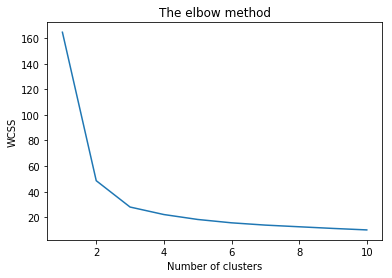

In [155]:
#Finding the optimum number of clusters for k-means classification
from sklearn.cluster import KMeans
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [158]:
#Applying kmeans to the dataset / Creating the kmeans classifier
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(X)

## References:

+ http://madhugnadig.com/articles/machine-learning/2017/03/04/implementing-k-means-clustering-from-scratch-in-python.html  
+ https://mubaris.com/posts/kmeans-clustering/